## SVM Application for Stroke Patient Classification and Data ##
Using healthcare data from Kaggle to classify patients that have had a stroke based on various health parameters and predict patients that will have a stroke based on these same parameters. In order to do this, I will be implementing an SVM. Results and conclusion at the bottom of this notebook. 

In [291]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

### Importing, preprocessing, and EDA ###

In [292]:
# Read in and examine data at a high level
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [293]:
# check for NA values and identify any values that need to be filled or removed
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

#### Based on this, I will perform KNN for BMI in order to fill the missing values. Refer to the cell after this one for KNN application. ####

Below I am replacing string value columns with binary 0 or 1 integers. I am also removing the columns that I do not plan to use in this analysis, as I will be only examining health and biometric related attributes with the excpetion of smoking.

In [294]:
# check types - change objects to ints
df = df[df['gender'] != 'Other']
df['gender'] = df['gender'].replace({'Male': 0, 'Female': 1})
df['ever_married'] = df['ever_married'].replace({'Yes': 1, 'No': 0})
df['Residence_type'] = df['Residence_type'].replace({'Urban': 0, 'Rural': 1})
# drop columns we will not be looking at 
df = df.drop('work_type', axis = 1)
df = df.drop('smoking_status', axis = 1)
df = df.drop('id', axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   int64  
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   int64  
 5   Residence_type     5109 non-null   int64  
 6   avg_glucose_level  5109 non-null   float64
 7   bmi                4908 non-null   float64
 8   stroke             5109 non-null   int64  
dtypes: float64(3), int64(6)
memory usage: 399.1 KB


/var/folders/c8/9qzx_q395b5_10ybqrn06fd80000gn/T/ipykernel_86566/993710068.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'] = df['gender'].replace({'Male': 0, 'Female': 1})
/var/folders/c8/9qzx_q395b5_10ybqrn06fd80000gn/T/ipykernel_86566/993710068.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['ever_married'] = df['ever_married'].replace({'Yes': 1, 'No': 0})
/var/folders/c8/9qzx_q395b5_10ybqrn06fd80000gn/T/ipykernel_86566/993710068.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and wil

### KNN ###
I first tested different values of k to determine which was the best based on the MSE. I did this by taking a sample and setting the true bmi values to NaN. Then, I calculate the MSE based on the imputed values and the true values and compare the MSE to then select the best k. 

In [309]:
# using KNN to fill missing values in BMI
# Create validation set
indices = df.index.to_list()
val_indices = np.random.choice(indices, size=200, replace=False)  
df_val = df.copy()
true_vals = df_val.loc[val_indices, 'bmi']
df_val.loc[val_indices, 'bmi'] = np.nan

# k = 2
knn2 = KNNImputer(n_neighbors=2)
df2 = pd.DataFrame(knn2.fit_transform(df_val), index=df_val.index, columns=df.columns)
imp2 = df2.loc[val_indices, 'bmi']
mask2 = ~imp2.isna() & ~true_vals.isna()
mse_2 = mean_squared_error(true_vals[mask2], imp2[mask2])
print(mse_2)

# k = 3
knn3 = KNNImputer(n_neighbors=3)
df3 = pd.DataFrame(knn3.fit_transform(df_val), index=df_val.index, columns=df.columns)
imp3 = df3.loc[val_indices, 'bmi']
mask3 = ~imp2.isna() & ~true_vals.isna()
mse_3 = mean_squared_error(true_vals[mask3], imp3[mask3])
print(mse_3)

# k = 4
knn4 = KNNImputer(n_neighbors=4)
df4 = pd.DataFrame(knn4.fit_transform(df_val), index=df_val.index, columns=df.columns)
imp4 = df4.loc[val_indices, 'bmi']
mask4 = ~imp4.isna() & ~true_vals.isna()
mse_4 = mean_squared_error(true_vals[mask4], imp4[mask4])
print(mse_4)

# k = 5
knn5 = KNNImputer(n_neighbors=5)
df5 = pd.DataFrame(knn5.fit_transform(df_val), index=df_val.index, columns=df.columns)
imp5 = df5.loc[val_indices, 'bmi']
mask5 = ~imp5.isna() & ~true_vals.isna()
mse_5 = mean_squared_error(true_vals[mask5], imp5[mask5])
print(mse_5)

# k = 6
knn6 = KNNImputer(n_neighbors=6)
df6 = pd.DataFrame(knn6.fit_transform(df_val), index=df_val.index, columns=df.columns)
imp6 = df6.loc[val_indices, 'bmi']
mask6 = ~imp6.isna() & ~true_vals.isna()
mse_6 = mean_squared_error(true_vals[mask6], imp6[mask6])
print(mse_6)

print(f'Best k based on MSE: {6}')

# Based on the above, 6 neighbors
imputer = KNNImputer(n_neighbors = 6)
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

51.63926180555555
48.930400000000006
45.88877647569445
45.85644655555556
41.261912461419755
Best k based on MSE: 6


### More EDA! ###
Examing data balance, correlation, and visualizing the relationships between the different attributes.

In [310]:
# check stroke variable, 1 being stroke, 0 being no stroke
df['stroke'].value_counts()

stroke
0.0    4860
1.0     249
Name: count, dtype: int64

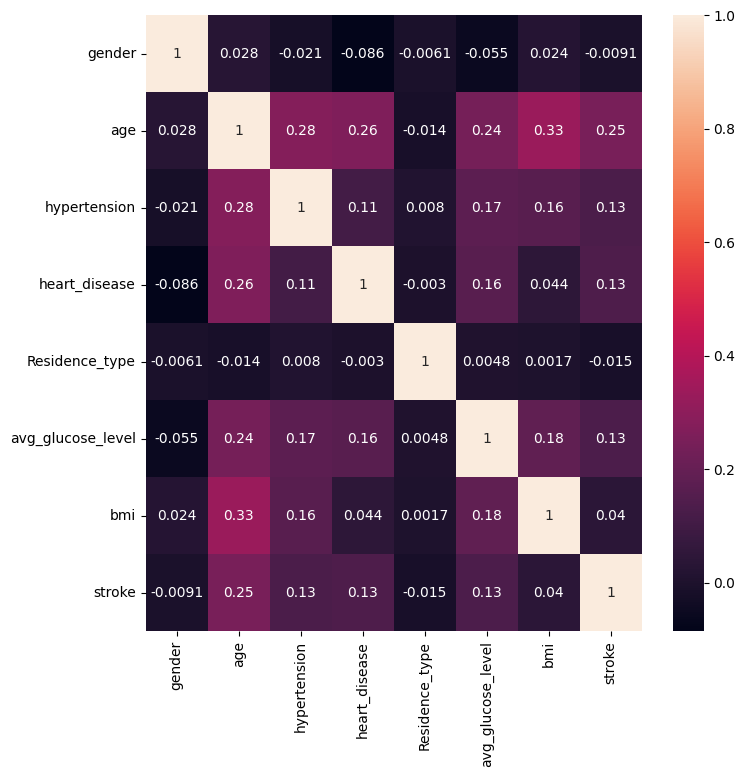

In [311]:
# EDA visualization - examining variable properties
# correlation matrix
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [313]:
# Choosing to drop ever_married
df = df.drop('ever_married', axis = 1)

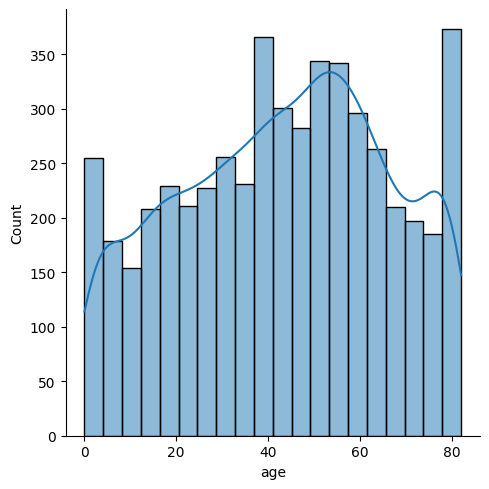

In [299]:
# Plotting the distribution of age and the kde of the distirbution
sns.displot(df['age'], kde =True)

Text(0, 0.5, 'Glucose')

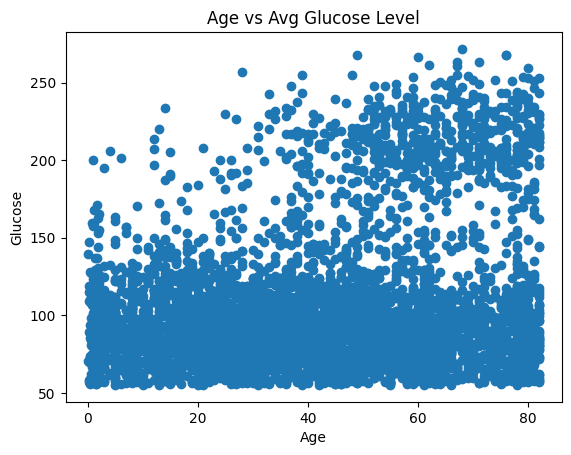

In [300]:
# Plot Age and Avg Glucose
plt.scatter('age', 'avg_glucose_level', data = df)
plt.title("Age vs Avg Glucose Level")
plt.xlabel("Age")
plt.ylabel("Glucose")

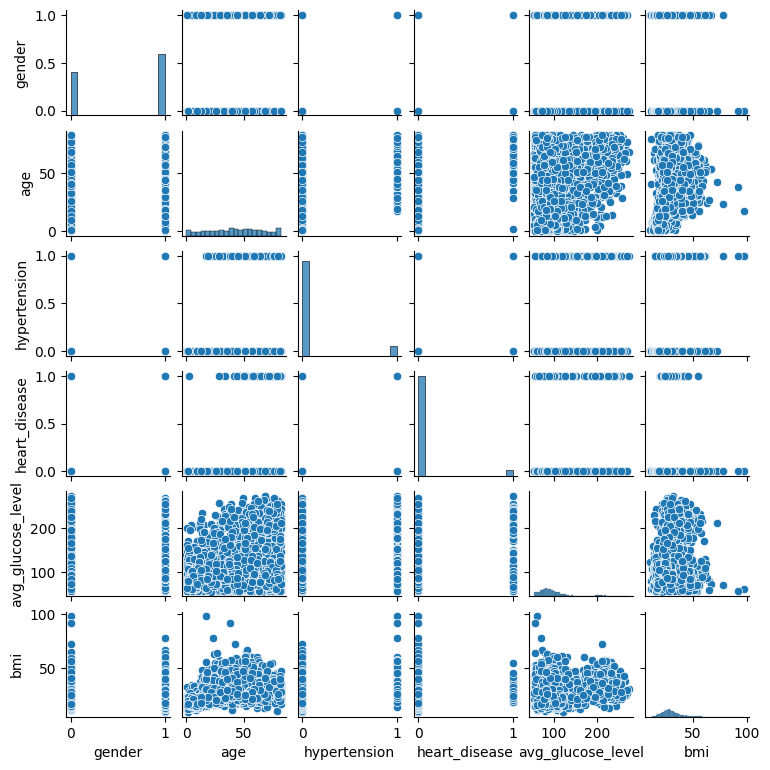

In [301]:
# Pairplot to look at all attributes
cols = ['gender', 'age', 'hypertension', 'heart_disease','avg_glucose_level', 'bmi']
sns.pairplot(df[cols], height = 1.3)

/var/folders/c8/9qzx_q395b5_10ybqrn06fd80000gn/T/ipykernel_86566/4193345475.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=groups.index)


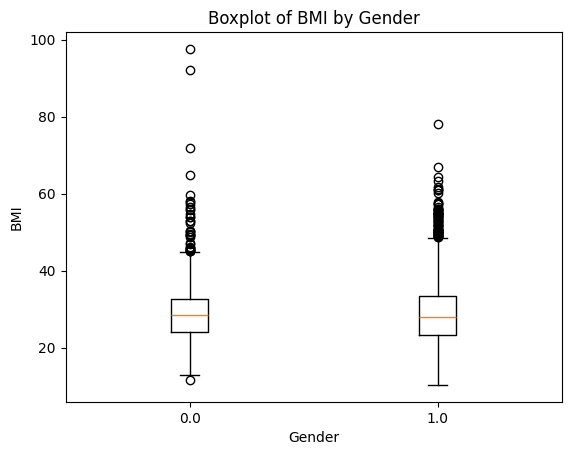

In [302]:
# Box Plot for Gender and Distribution of BMI
groups = df.groupby('gender')['bmi'].apply(list)
data = [groups[gender] for gender in groups.index]
plt.boxplot(data, labels=groups.index)

plt.xlabel('Gender')
plt.ylabel('BMI')
plt.title('Boxplot of BMI by Gender')
plt.show()

### Model Training and Data Standardization ###
Here we will split the dataset into training and testing, then standardize the X data (both train and test sets). The data needs to be standardized because the attributes have various ranges (binary, 0-100, and 0-250). 

In [314]:
# Split into training and testing data
X = df.drop('stroke', axis=1)
y = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [315]:
# Scale and standardize
scaler = StandardScaler()            
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### SVM Application (First Iteration) ###
Since the correlation between the chosen attributes is low or almost 0, I will not be doing any feature selection for this first iteration to see how well the model works with all the chosen attributes. Here I have chosen to use the 'class_weight' parameter in the SVC function in order to account for the imbalance in the data. On this note, I will also be focusing more on the F1 scoring due to the imbalance. F1 is a more robust metric to use in a situation where the data is greatly imbalanced. Additionally, since there are different types of relationships between the attributes (not all linear), I have chosen to use the polynomial kernel. This kernel provided the best F1 results, as well as the highest accuracy score. 

In [323]:
# SVM Application
svm = SVC(class_weight = 'balanced', kernel = 'poly', C = 1)  
cv_scores = cross_val_score(svm, X_train_scaled, y_train, cv = 5, scoring = 'f1')
svm.fit(X_train_scaled, y_train)
y_pred = svm.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(accuracy)

              precision    recall  f1-score   support

         0.0       0.98      0.77      0.86      1444
         1.0       0.16      0.69      0.25        89

    accuracy                           0.77      1533
   macro avg       0.57      0.73      0.56      1533
weighted avg       0.93      0.77      0.83      1533

0.7651663405088063


### SVM with Resampling (Second Iteration) ###
Due to the imnbalance, I have chosen to resample the data and oversample the minority class (patients that have had a stroke) using the SMOTE package. After implementing this change there is a slight increase in the F1 score, but nothing that signifies improvement upon the previous model iteration. The recall is also slightly higher, but there is not enough of a difference for this model to be considered an improvement upon the first iteration.

In [305]:
# SVM with Resampling
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Try model with resampling
svm_r = SVC(class_weight = 'balanced', kernel = 'poly', C = 1)  
cv_scores = cross_val_score(svm_r, X_resampled, y_resampled, cv = 5, scoring = 'f1')
svm_r.fit(X_resampled, y_resampled)
y_pred = svm_r.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(accuracy)

              precision    recall  f1-score   support

         0.0       0.98      0.78      0.87      1444
         1.0       0.16      0.67      0.26        89

    accuracy                           0.78      1533
   macro avg       0.57      0.73      0.56      1533
weighted avg       0.93      0.78      0.83      1533

0.7775603392041748


### Visualizing Results ###
Using a learning curve, we can better assess where the model can be improved. Below, we see that decreasing the sample size may improve the accuracy. Additionally, I have provided a confusion matrix to visualize where the model accurately prediction outcomes. We see it performed very poorly on predicting patients that had a reported/confirmed stroke. It performed better on predicting patients that did not have reported strokes.

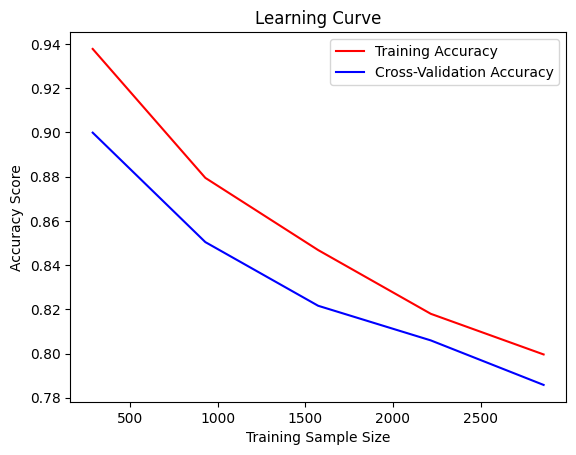

In [306]:
# Show learning curve
train_sizes, train_scores, test_scores = learning_curve(svm_r, X_train_scaled, y_train, scoring='accuracy')

plt.plot(train_sizes, np.mean(train_scores, axis = 1), label = "Training Accuracy", color = "red")
plt.plot(train_sizes, np.mean(test_scores, axis = 1), label = "Cross-Validation Accuracy", color = "blue")
plt.title("Learning Curve")
plt.xlabel("Training Sample Size")
plt.ylabel("Accuracy Score")
plt.legend()
plt.show()

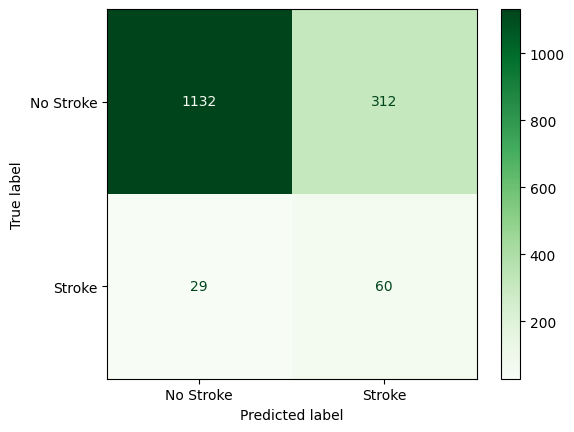

In [307]:
# Predict on test data
y_pred = svm_r.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['No Stroke', 'Stroke'])
disp.plot(cmap = 'Greens')
plt.show()

### Conclusion ###
In conclusion, a better model could have been chosen for this data. The imbalance in the data may also need to be addressed differently in order for an SVM to perform better on this data set. Secondly, a decrease in sample size may result in better model results and not cause overfitting as we see above. This dataset may have been easier to analyze, classify, and predict using a random forest model. This is because random forests are more robust to imbalanced data than SVMs. This model showed bias towards the majority class (No Stroke). All in all, this specific model would not be a great diagnostic model for whether or not a patient is at risk for a stroke. 

In the context of the problem and real life, strokes can be difficult to predict as they can be induced by a number of different things including stress, head trauma, other injuries or diseases, and a variety  of other reasons. Another solution may be to add more parameters, such as smoking (which was not included in this model) or adding new data such as weight, diabetes (yes or no), or average number of hours worked per week. 